## _*H2 energy plot comparing full to particle hole transformations*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE and UCCSD with full and particle hole transformations. It is compared to the same energies as computed by the ExactEigensolver

This notebook has been written to use the PYQUANTE chemistry driver. See the PYQUANTE chemistry driver readme if you need to install the external PyQuante2 library that this driver requires.

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.chemistry.drivers import PyQuanteDriver, BasisType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD

molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = ['VQE', 'ExactEigensolver']
transformations = [TransformationType.FULL, TransformationType.PARTICLE_HOLE]

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(transformations), len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.empty([len(transformations), steps+1])

aqua_globals.random_seed = 50

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    for j in range(len(algorithms)):
        for k in range(len(transformations)):  
            driver = PyQuanteDriver(atoms=molecule.format(d/2), basis=BasisType.BSTO3G)
            qmolecule = driver.run()
            operator =  Hamiltonian(transformation=transformations[k],
                                    qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                    two_qubit_reduction=False)
            qubit_op, aux_ops = operator.run(qmolecule)
            if algorithms[j] == 'ExactEigensolver':
                result = ExactEigensolver(qubit_op).run()
            else:
                optimizer = COBYLA(maxiter=10000)
                initial_state = HartreeFock(qubit_op.num_qubits,
                                        operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
                var_form = UCCSD(qubit_op.num_qubits, depth=1,
                                    num_orbitals=operator.molecule_info['num_orbitals'],
                                    num_particles=operator.molecule_info['num_particles'],
                                    initial_state=initial_state,
                                    qubit_mapping=operator._qubit_mapping,
                                    two_qubit_reduction=operator._two_qubit_reduction)
                algo = VQE(qubit_op, var_form, optimizer)
                result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed))
        
            lines, result = operator.process_algorithm_result(result)
            result['printable'] = lines
            energies[k][j][i] = result['energy']
            hf_energies[i] = result['hf_energy']
            if algorithms[j] == 'VQE':
                eval_counts[k][i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)


Couldn't find cython int routine
Couldn't find cython int routine
Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[[-1.05515974 -1.07591359 -1.09262986 -1.105918   -1.11628598
   -1.12416087 -1.12990474 -1.1338262  -1.13618942 -1.13722135
   -1.13711705 -1.13604435 -1.13414767 -1.1315512  -1.12836188
   -1.12467175 -1.12056029 -1.11609624 -1.11133942 -1.10634212
   -1.10115032]
  [-1.05515975 -1.07591362 -1.09262988 -1.10591802 -1.11628599
   -1.1241609  -1.12990477 -1.13382621 -1.13618945 -1.13722136
   -1.13711707 -1.13604437 -1.13414767 -1.13155121 -1.12836189
   -1.12467176 -1.12056029 -1.11609625 -1.11133943 -1.10634212
   -1.10115034]]

 [[-1.05515974 -1.07591361 -1.09262987 -1.105918   -1.11628598
   -1.12416089 -1.12990474 -1.13382619 -1.13618943 -1.13722135
   -1.13711704 -1.13604436 -1.13414767 -1.1315512  -1.12836188
   -1.12467175 -1.120560

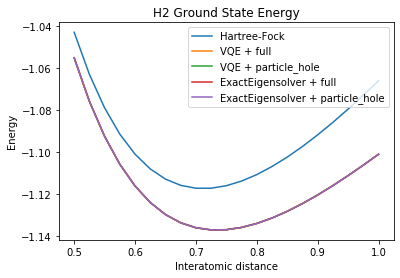

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    for k in range(len(transformations)):
        pylab.plot(distances, energies[k][j], label=algorithms[j]+' + '+transformations[k].value)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

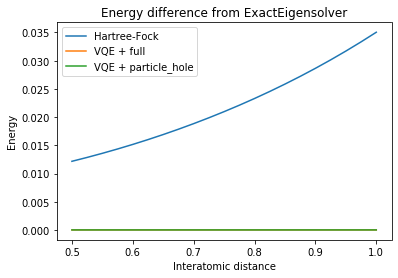

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[0][1]), label='Hartree-Fock')
for k in range(len(transformations)):
    pylab.plot(distances, np.subtract(energies[k][0], energies[k][1]), label='VQE + '+transformations[k].value)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left');

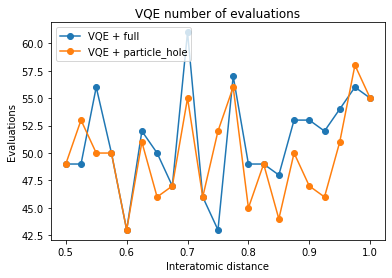

In [4]:
for k in range(len(transformations)):
    pylab.plot(distances, eval_counts[k], '-o', label='VQE + ' + transformations[k].value)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='upper left');